<a href="https://colab.research.google.com/github/dgamay/20.clase/blob/main/AUTO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# --- 1. INSTALACIÓN ---
!pip install selenium webdriver-manager
!apt-get update
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!apt install -y ./google-chrome-stable_current_amd64.deb

import os
import time
import re
import pandas as pd
from datetime import datetime
from google.colab import files
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

# --- LIMPIEZA TOTAL DE ARCHIVOS PREVIOS ---
for f in os.listdir():
    if f.endswith(".xlsx"):
        os.remove(f)

# --- CREDENCIALES ---
USER = "robinson amaya"
PASS = "1059906535"
CLIENTE_ID = "1068"

def setup_driver_colab():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")
    options.binary_location = "/usr/bin/google-chrome"
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=options)

def ejecutar_proceso_colab():
    print("📁 Sube el archivo Excel:")
    uploaded = files.upload()
    if not uploaded: return

    nombre_archivo = list(uploaded.keys())[0]
    df = pd.read_excel(nombre_archivo)
    df['Resultado_Carga'] = 'Pendiente'

    driver = setup_driver_colab()
    wait = WebDriverWait(driver, 15)

    try:
        # --- LOGIN ---
        driver.get("https://ups.honorlaurel.com/ups/index.php?r=site/login")
        wait.until(EC.presence_of_element_located((By.ID, "LoginForm_username"))).send_keys(USER)
        driver.find_element(By.ID, "LoginForm_password").send_keys(PASS)
        driver.find_element(By.NAME, "yt0").click()

        for index, row in tqdm(df.iterrows(), total=len(df), desc="Procesando"):
            try:
                # El nombre del Excel SOLO se usa para buscar
                termino_busqueda = str(row['Sitio']).strip()
                nueva_direccion = str(row['DIRECCION COMPLETA']).strip()
                nuevo_abonado = str(row['ABONADO']).strip()

                driver.get("https://ups.honorlaurel.com/ups/index.php?r=clientOffice")
                search = wait.until(EC.element_to_be_clickable((By.NAME, "ClientOffice[name]")))
                search.clear()
                search.send_keys(termino_busqueda + Keys.ENTER)
                time.sleep(3) # Tiempo para que la tabla cargue resultados

                filas = driver.find_elements(By.XPATH, "//table/tbody/tr[contains(@class, 'odd') or contains(@class, 'even')]")

                if "No se encontraron resultados" in driver.page_source or len(filas) == 0:
                    # CREACIÓN: Aquí sí usamos el nombre del Excel porque no existe en la web
                    driver.get("https://ups.honorlaurel.com/ups/index.php?r=clientOffice/create")
                    wait.until(EC.presence_of_element_located((By.ID, "ClientOffice_name")))
                    driver.find_element(By.ID, "ClientOffice_name").send_keys(termino_busqueda)
                    driver.find_element(By.ID, "ClientOffice_address").send_keys(nueva_direccion)
                    driver.find_element(By.ID, "ClientOffice_abonado").send_keys(nuevo_abonado)
                    Select(driver.find_element(By.ID, "ClientOffice_client_id")).select_by_value(CLIENTE_ID)
                    driver.execute_script("arguments[0].click();", driver.find_element(By.ID, "ClientOffice_active_0"))
                    driver.find_element(By.NAME, "yt0").click()
                    df.at[index, 'Resultado_Carga'] = 'CREADO'
                    continue

                # --- PROCESAR EXISTENTES ---
                registros_encontrados = []
                for f in filas:
                    cols = f.find_elements(By.TAG_NAME, "td")
                    id_web = int(re.sub(r'\D', '', cols[0].text))
                    nombre_web = cols[1].text.strip() # CAPTURAMOS EL NOMBRE REAL DE LA PLATAFORMA
                    url_edit = f.find_element(By.CSS_SELECTOR, "a.update").get_attribute("href")
                    registros_encontrados.append({'id': id_web, 'nombre': nombre_web, 'url': url_edit})

                # Ordenar por ID (Menor a Mayor)
                registros_encontrados.sort(key=lambda x: x['id'])

                for i, reg in enumerate(registros_encontrados):
                    driver.get(reg['url'])
                    wait.until(EC.visibility_of_element_located((By.ID, "ClientOffice_name")))

                    # 1. Limpiamos el nombre de etiquetas viejas para tener el nombre real
                    nombre_limpio = reg['nombre'].replace("(INACTIVA DUPLICADA)", "").strip()

                    # 2. Escribimos los datos respetando el nombre de la WEB
                    input_nom = driver.find_element(By.ID, "ClientOffice_name")
                    input_nom.clear()

                    if i == 0: # Principal
                        input_nom.send_keys(nombre_limpio)
                        driver.execute_script("arguments[0].click();", driver.find_element(By.ID, "ClientOffice_active_0"))
                    else: # Duplicado
                        input_nom.send_keys(f"{nombre_limpio} (INACTIVA DUPLICADA)")
                        driver.execute_script("arguments[0].click();", driver.find_element(By.ID, "ClientOffice_active_1"))

                    # Dirección y Abonado
                    input_dir = driver.find_element(By.ID, "ClientOffice_address")
                    input_dir.clear(); input_dir.send_keys(nueva_direccion)
                    input_abo = driver.find_element(By.ID, "ClientOffice_abonado")
                    input_abo.clear(); input_abo.send_keys(nuevo_abonado)

                    driver.find_element(By.NAME, "yt0").click()

                df.at[index, 'Resultado_Carga'] = f'LISTO ({len(registros_encontrados)})'

            except Exception as e:
                df.at[index, 'Resultado_Carga'] = f"ERROR: {str(e)[:20]}"

    finally:
        driver.quit()
        out = f"reporte_{datetime.now().strftime('%H%M')}.xlsx"
        df.to_excel(out, index=False)
        files.download(out)

ejecutar_proceso_colab()

Hit:1 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
--2026-02-18 18:23:42--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.g

Saving P4.xlsx to P4.xlsx


Procesando: 100%|██████████| 2/2 [00:31<00:00, 15.79s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
#!pip uninstall -y selenium
!pip install selenium==4.21.0 webdriver-manager
!apt-get update
!apt-get install -y chromium-browser

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (4,102 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:

In [2]:
def setup_driver_colab():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")  # Crucial para evitar crash en Colab
    options.add_argument("--remote-debugging-port=9222")
    options.add_argument("--window-size=1920,1080")

    # Especificar la ubicación del binario de Chromium
    options.binary_location = "/usr/bin/chromium-browser"

    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=options)

First, we need to upload your Excel file. You can drag and drop your file into the Colab file browser (on the left sidebar, click the folder icon) or use the following code to upload it directly. **Make sure to rename `your_excel_file.xlsx` to the actual name of your file if you choose to use the upload widget.**

In [ ]:
from google.colab import files

# This will open a file picker dialog
uploaded = files.upload()

# Assuming you upload one file, get its name
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}"')
  excel_file_name = fn
  break

# If you already uploaded the file manually or know the name, you can set it directly:
# excel_file_name = 'tu_archivo.xlsx' # Replace with your actual file name

Saving prueba2.xlsx to prueba2 (1).xlsx
User uploaded file "prueba2 (1).xlsx"


Now, let's load the uploaded Excel file into a pandas DataFrame and then execute the `automatizar_web` function with your data.

Successfully loaded 'prueba2 (1).xlsx' into a DataFrame. Displaying the first 5 rows:


,ABONADO,Sitio,Region,Municipio,sucursal detalle,DIRECCION COMPLETA
0,2210,Cav Zipaquirá,R4-Centro,Bogota D C,1001.0,Bogota D C Cra 91 # 141A - 52 Local 102
1,5103,Cav.Soacha Ventura,R3-Suroccidente,Cali,3001.0,Valle del Cauca Cali Calle 34AN # 2BN-120 Edif...
2,5557,Cav.Tunja Viva,R1-Costa,Santa Marta,2003.0,Santa Marta Calle 23 # 4 - 27 Of.902 Ed. Centr...
3,CC99,Ccm Acopi,R4-Centro,Bogota D C,1001.0,Bogota D C TRAN 84C No127G-52
4,5004,Ccm Bancolombia,R2-Noroccidente,Medellin,NaN,- Medellin Carrera55a # 49 88



Starting web automation...
✅ Inicio de sesión y navegación inicial completada.


Procesando Sitios:   0%|          | 0/15 [00:00<?, ?it/s]

📸 Resultado final del Sitio: Cav Zipaquirá


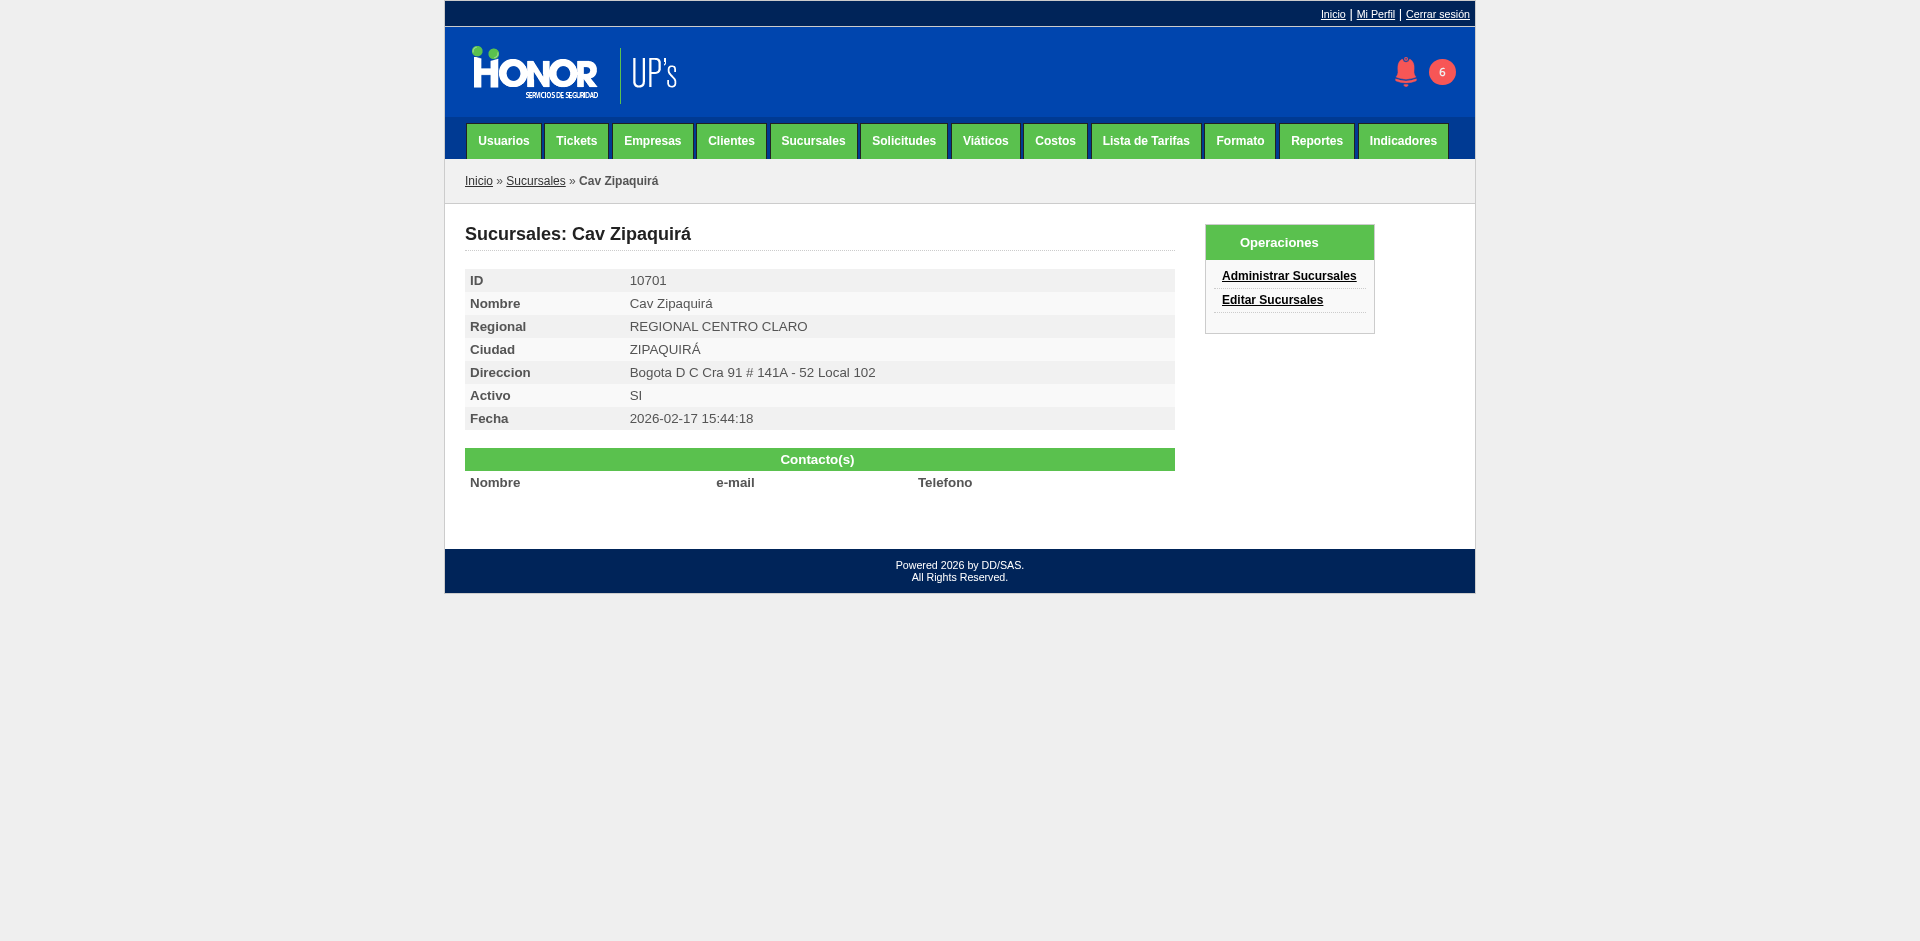

Procesando Sitios:   7%|▋         | 1/15 [00:21<05:01, 21.52s/it]

🔴 Error crítico: Message: 
Stacktrace:
#0 0x57b47f2c9dba <unknown>
#1 0x57b47ecd9682 <unknown>
#2 0x57b47ed2ea06 <unknown>
#3 0x57b47ed2ec41 <unknown>
#4 0x57b47ed79e14 <unknown>
#5 0x57b47ed7704b <unknown>
#6 0x57b47ed2088f <unknown>
#7 0x57b47ed21651 <unknown>
#8 0x57b47f28e209 <unknown>
#9 0x57b47f291111 <unknown>
#10 0x57b47f27a9c9 <unknown>
#11 0x57b47f291cde <unknown>
#12 0x57b47f260d40 <unknown>
#13 0x57b47f2b6408 <unknown>
#14 0x57b47f2b65d8 <unknown>
#15 0x57b47f2c8403 <unknown>
#16 0x7b9a4906cac3 <unknown>

📸 Error capturado


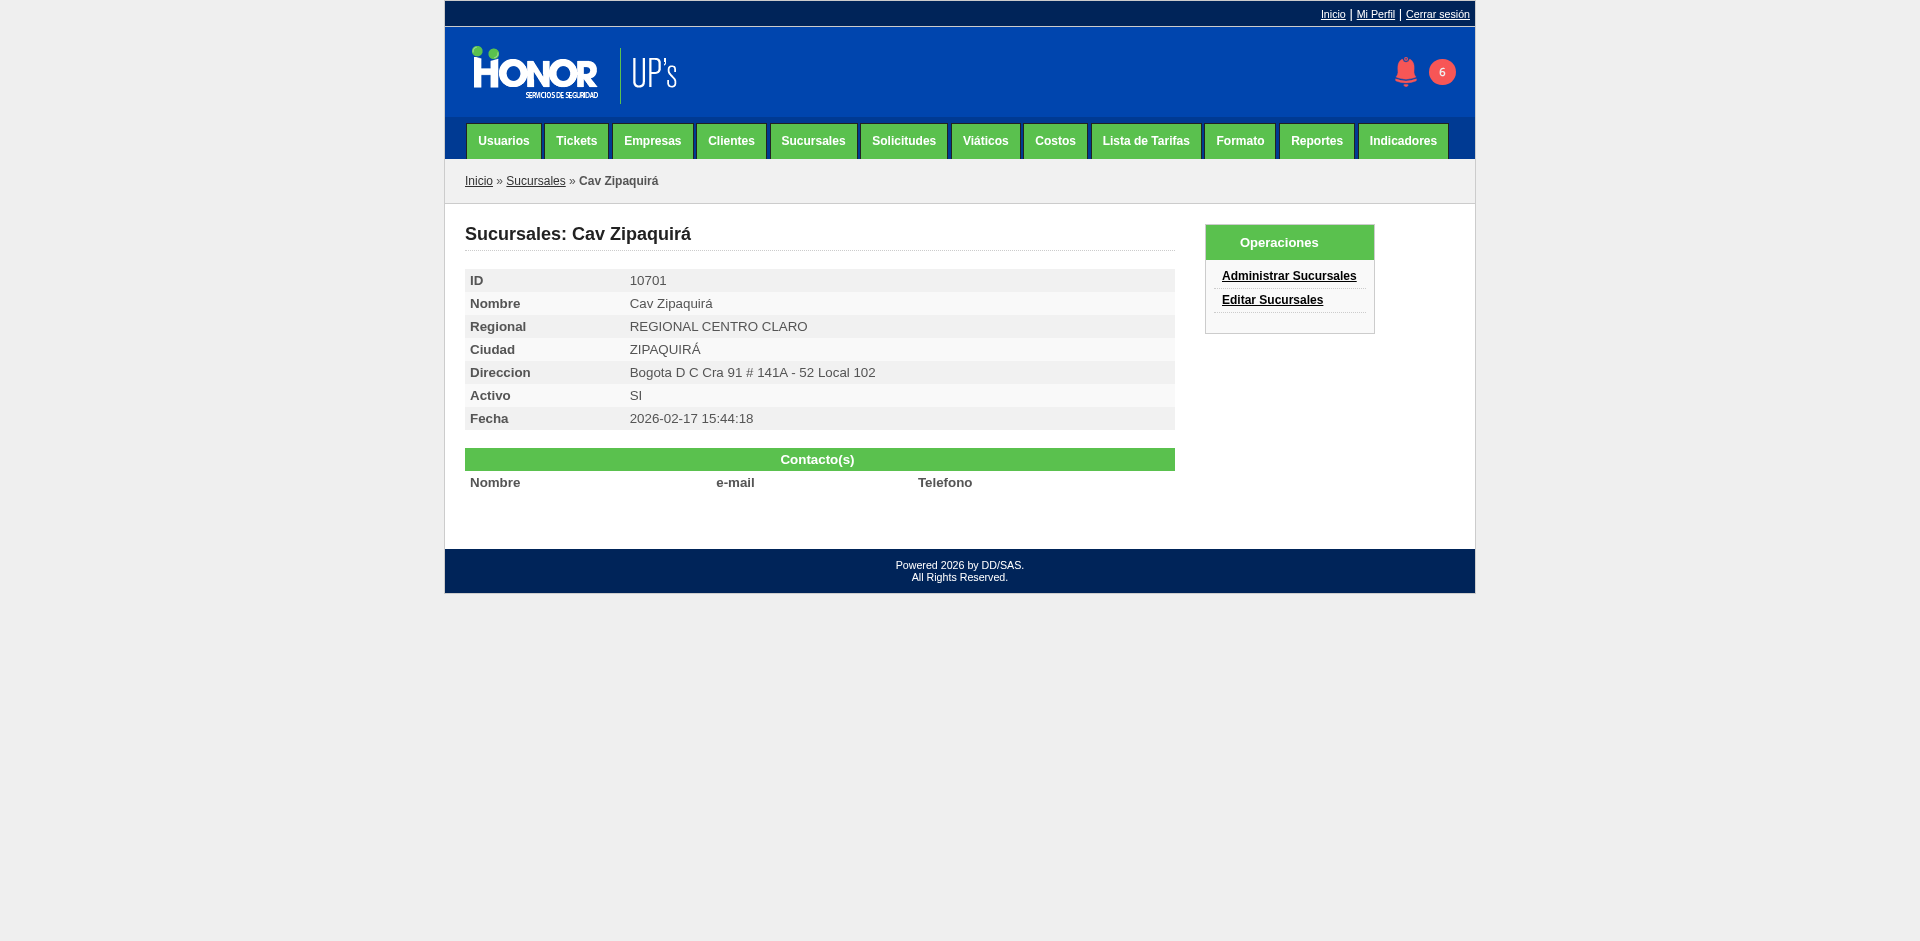

🏁 Proceso finalizado.
Web automation process completed.


In [ ]:
import pandas as pd

try:
    # Load the Excel file into a pandas DataFrame
    df = pd.read_excel(excel_file_name)
    print(f"Successfully loaded '{excel_file_name}' into a DataFrame. Displaying the first 5 rows:")
    display(df.head())

    # Execute the web automation script
    print("\nStarting web automation...")
    automatizar_web(df)
    print("Web automation process completed.")

except NameError:
    print("Error: No Excel file name was set. Please run the upload cell above or set 'excel_file_name' manually.")
except FileNotFoundError:
    print(f"Error: The file '{excel_file_name}' was not found. Please ensure the file is uploaded and the name is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Primero, necesitamos cargar tu archivo Excel. Puedes arrastrar y soltar tu archivo en el explorador de archivos de Colab (en la barra lateral izquierda, haz clic en el icono de la carpeta) o usar el siguiente código para cargarlo directamente. **Asegúrate de cambiar el nombre de `your_excel_file.xlsx` por el nombre real de tu archivo si eliges usar el widget de carga.**

In [ ]:
from google.colab import files

# Esto abrirá un cuadro de diálogo para seleccionar archivos
uploaded = files.upload()

# Suponiendo que subes un archivo, obtén su nombre
for fn in uploaded.keys():
  print(f'Archivo subido por el usuario "{fn}"')
  excel_file_name = fn
  break

# Si ya subiste el archivo manualmente o conoces el nombre, puedes configurarlo directamente:
# excel_file_name = 'tu_archivo.xlsx' # Reemplaza con el nombre real de tu archivo

Saving prueba automatizacion.xlsx to prueba automatizacion (1).xlsx
Archivo subido por el usuario "prueba automatizacion (1).xlsx"


Ahora, vamos a cargar el archivo Excel subido en un DataFrame de pandas y luego ejecutar la función `automatizar_web` con tus datos.

In [ ]:
import pandas as pd

try:
    # Cargar el archivo Excel en un DataFrame de pandas
    df = pd.read_excel(excel_file_name)
    print(f"Se cargó correctamente '{excel_file_name}' en un DataFrame. Mostrando las primeras 5 filas:")
    display(df.head())

    total_records_in_excel = len(df)
    print(f"\nEl archivo Excel tiene {total_records_in_excel} registros disponibles para automatizar.")

    # Ask the user for the number of records to process
    num_to_process_str = input(f"¿Cuántos registros deseas procesar? (Introduce un número, o deja en blanco para todos los {total_records_in_excel}): ")

    num_to_process = None
    if num_to_process_str.strip().isdigit():
        num_to_process = int(num_to_process_str.strip())
        if num_to_process <= 0 or num_to_process > total_records_in_excel:
            print(f"Número inválido. Se procesarán todos los {total_records_in_excel} registros.")
            num_to_process = None
    elif num_to_process_str.strip() != '': # If not empty and not a digit, assume all
        print(f"Entrada no válida. Se procesarán todos los {total_records_in_excel} registros.")
        num_to_process = None


    # Execute the web automation script
    print("\nIniciando la automatización web...")
    automatizar_web(df, num_records_to_process=num_to_process)
    print("Proceso de automatización web completado.")

except NameError:
    print("Error: No se ha establecido el nombre del archivo Excel. Por favor, ejecuta la celda de carga de arriba o establece 'excel_file_name' manualmente.")
except FileNotFoundError:
    print(f"Error: El archivo '{excel_file_name}' no fue encontrado. Asegúrate de que el archivo esté subido y el nombre sea correcto.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Se cargó correctamente 'prueba automatizacion (1).xlsx' en un DataFrame. Mostrando las primeras 5 filas:


,ABONADO,Sitio,Region,Municipio,sucursal detalle,DIRECCION COMPLETA
0,D907,CES.Aguachica-1,R1-Costa,Aguachica,4057.0,Cesar Aguachica Estación de servicio Bucaraman...
1,D906,CES.Aguachica-2,R1-Costa,Aguachica,4057.0,Cesar Aguachica Calle 5 # 1-30 8.312111 -73.63...
2,D905,CES.Aguachica-3,R1-Costa,Aguachica,4057.0,Cesar Aguachica Km 2 vía La Mata saliendo de A...
3,D442,CES.Aguachica-4,R1-Costa,Aguachica,4057.0,Cesar Aguachica CRA 24 A con CLL 5 8.310583 -7...
4,D160,CES.Aguachica-5,R1-Costa,Aguachica,4057.0,Cesar Aguachica CALLE 10 CARRERA 15 A ESQUINA ...



El archivo Excel tiene 15 registros disponibles para automatizar.
¿Cuántos registros deseas procesar? (Introduce un número, o deja en blanco para todos los 15): 15

Iniciando la automatización web...
Ocurrió un error inesperado: automatizar_web() got an unexpected keyword argument 'num_records_to_process'
